[Text(0.5, 1.0, 'Threading, Sub Interpreter and Multiprocessing Benchmark (n=60) Python 3.12.0a7+ (64-bit) revision e1dde486ef'),
 Text(0, 0.5, 'Mean Time for 100 executions (s)'),
 Text(0.5, 0, 'Model')]

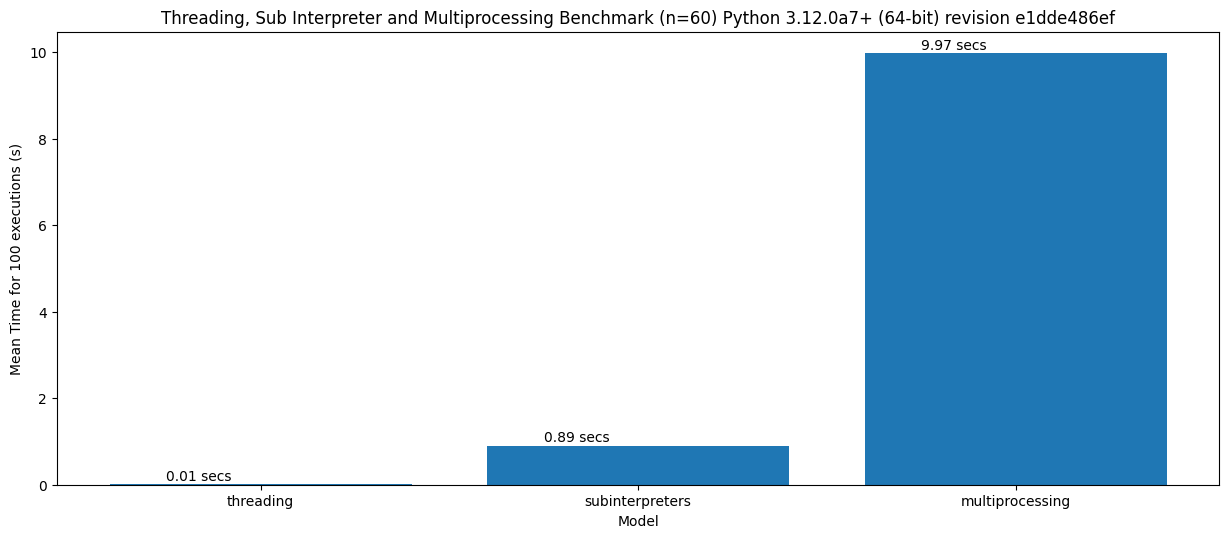

In [12]:
import json
import matplotlib.pyplot as plt
from statistics import mean

plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["figure.dpi"] = 100

with open("test1.json") as f:
    data = json.load(f)
    runs = {}
    for benchmark in data["benchmarks"]:
        run_times = []
        for run in benchmark["runs"]:
            if "values" in run:
                run_times.extend(run["values"])
        runs[benchmark["metadata"]["name"]] = mean(run_times)
        # plt.hist(run_times, bins=50, label=benchmark["metadata"]["name"], alpha=0.5)
    python_version = data["metadata"]["python_version"]

# Create a bar chart of each run
plt.bar(runs.keys(), runs.values())
# Make Y scale log
# plt.yscale('log')
# put the value on top of the bar
for i, v in enumerate(runs.values()):
    plt.text(i - 0.25, v + 0.1, f"{round(v, 2)} secs", color='black')

plt.gca().set(title=f'Threading, Sub Interpreter and Multiprocessing Benchmark (n={len(run_times)}) Python {python_version}', ylabel='Mean Time for 100 executions (s)', xlabel='Model')